In [3]:
# change to the /srv/jupyter/$username directory where we have write permission
import os;
import pwd;
# change to a directory where we have write permission
#os.chdir(os.path.join("/srv/jupyter", pwd.getpwuid(os.getuid()).pw_name));
os.chdir("./")

# OCR Experiment

In this notebook we will be implementing a simple OCR experiment using TensorFlow.

## Let's start with some data:

Consider the following file, <i>digits.txt</i> (if you run the cell below (a copy of the file will be created for you).

In [4]:
%%file digits.txt
00000   11111   22222   33333   44444   55555   66666   77777   88888   99999
 XXX      X      XXX     XXX       X    XXXXX    XXX    XXXXX    XXX     XXX 
X   X    XX         X       X     XX    X       X          X    X   X   X   X
X   X     X        X     XXX     X X    XXXX    XXXX      X      XXX     XXXX
X   X     X       X         X   XXXXX       X   X   X    X      X   X       X
 XXX     XXX    XXXXX    XXX       X    XXXX     XXX    X        XXX     XXX 

Overwriting digits.txt


Now let's store these digit images in a python dictionary.

In [5]:
fp = open( "digits.txt");
lines = fp.readlines();
fp.close();

image = { i:'' for i in range(0,10) };
for line in lines[1:]:  # start with the second line
    for digit in range(0,10):
        image[digit] += line[0:5]+'\n';
        line = line[8:];

## Printing the images.

In [6]:
for digit in range(0,10):
    print (image[digit]);
    print;

 XXX 
X   X
X   X
X   X
 XXX 


  X  
 XX  
  X  
  X  
 XXX 


 XXX 
    X
   X 
  X  
XXXXX


 XXX 
    X
 XXX 
    X
 XXX 


   X 
  XX 
 X X 
XXXXX
   X 


XXXXX
X    
XXXX 
    X
XXXX 


 XXX 
X    
XXXX 
X   X
 XXX 


XXXXX
   X 
  X  
 X   
X    


 XXX 
X   X
 XXX 
X   X
 XXX 


 XXX 
X   X
 XXXX
    X
 XXX 




## Input data
In order to present these images to a network, we will need to encode them numerically.  We can do this by representing the dark ("X") pixels with ones and the light (" ") pixels with zeros.  Here's a handy function for that.

In [7]:
def image2bits( image ):
    "convert image to bits by coding X as 1 and blank as 0; ignore newlines"
    return [ int(c=='X') for c in image if c!='\n' ];

Now we can use this to transfor any image to an <i>input vector</i>.

In [8]:
print (image2bits( image[0] ));

[0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0]


In [9]:
print (image2bits( image[1] ));

[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]


In [10]:
print (image2bits( image[9] ));

[0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0]


It will also be useful to reverse the operation so that we can take an <i>input vector</i> and visualize it as an image.  Here's the function for that.

In [11]:
def bits2image( bits ):
    "convert bits to an image by coding 0 as blank and 1 as X; add newlines"
    lines = [ bits[j:j+5] for j in range(0, len(bits), 5) ];
    return "\n".join([ "".join([ " X"[i] for i in line]) for line in lines ]);

See, it works:

In [12]:
print (bits2image( image2bits( image[0] ) ));

 XXX 
X   X
X   X
X   X
 XXX 


In [13]:
print (bits2image( image2bits( image[1] ) ));

  X  
 XX  
  X  
  X  
 XXX 


## Output data
We also need output data.  In this case there will be 10 different classes of outputs.  A simple and popular output encoding is call the one-hot encoding.  In this scheme the n=10 different classes of outputs are represented by 10 different vectors, each vector being all zeros, except along a single dimension (where it is one).  Here's the function that genarates one-hot vectors:

In [14]:
def onehot(i,n):
    "return a list of n values with the ith value set to one"
    return [ int(i==j) for j in range(0,n)];

The digit 0 is encoded as:

In [15]:
print (onehot(0,10));

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


While digit 1 is represented as:

In [16]:
print (onehot(1,10));

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


And the last digit (9) is encoded as:

In [17]:
print (onehot(9,10));

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


There are other ways of encoding the output.  For example, we could have used a 4-digit binary representation:
<table>
  <tr>
    <td>0</td><td>0,0,0,0</td>
  </tr>
  <tr>
    <td>1</td><td>0,0,0,1</td>
  </tr>
  <tr>
    <td>2</td><td>0,0,1,0</td>
  </tr>
  <tr>
    <td>3</td><td>0,0,1,1</td>
  </tr>
  <tr>
    <td>4</td><td>0,1,0,0</td>
  </tr>
  <tr>
    <td>5</td><td>0,1,0,1</td>
  </tr>
  <tr>
    <td>6</td><td>0,1,1,0</td>
  </tr>
  <tr>
    <td>7</td><td>0,1,1,1</td>
  </tr>
  <tr>
    <td>8</td><td>1,0,0,0</td>
  </tr>
  <tr>
    <td>9</td><td>1,0,0,1</td>
  </tr>
</table>
But, note that in this representation the distances between output vectors is incosistent.  E.g. (0,1,1,0) and (1,0,0,1) are much further (by most norms) than (0,0,0,0) and (0,0,0,1).  This biases the system to treat some output patters as more similar than others.

## Input/Output pairs can be generated as follows:

In [18]:
print ( image2bits( image[0] ), onehot(0,10) );

([0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [19]:
import numpy as np;
DTYPE = 'float32'

def perfect_data():
    input_array = np.array([ image2bits( image[digit] ) for digit in range(0,10) ]);
    output_array = np.array([ onehot(digit,10) for digit in range(0,10) ]);
    return input_array.astype(DTYPE), output_array.astype(DTYPE);

In [20]:
print (perfect_data());

(array([[ 0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
         0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.],
       [ 0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,
         1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.],
       [ 0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
         1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.],
     

## Adding Noise
This is very much a toy problem, but let's make it a little bit interesting, but adding noise.

We'll use a simple noise model that flips the pixels with a given probability.  Essentially we go though each dimension in the input vector and generate a random number between 0 and 1.  If it is below our noise probability we flip the pixel, otherwise we leave it alone.  Here's a function to apply this kind of noise to input vectors.

In [21]:
import random;

def addnoise( input, noise ):
    return [ i^(random.random()<noise) for i in input ];

We can test what happens when the noise probability is 0.0 - zero chance of flipping any of the bits:  nothing happens.

In [22]:
print (bits2image( addnoise( image2bits( image[0] ), 0.0 ) ));

 XXX 
X   X
X   X
X   X
 XXX 


With a probability of 1.0, the output is not random, but rather a negative image (inverse).

In [23]:
print (bits2image( addnoise( image2bits( image[0] ), 1.00 ) ));

X   X
 XXX 
 XXX 
 XXX 
X   X


With a 0.5 probability, the image becomes completely random because each bit has an equal probability of remainining what it was versus changing, so each bit has a 50/50 chance of being 1 or 0.

In [24]:
print (bits2image( addnoise( image2bits( image[0] ), 0.50 ) ));

    X
XXXXX
XXXXX
X    
X XX 


Here's a loop that generates the image 0 with noise levels ranging from 0-100% at 5% intervals.

In [25]:
for noise in range( 0, 101, 5 ):
    print ("Noise: %3d%%\n" % noise);
    print (bits2image( addnoise( image2bits( image[0] ), noise/100.0) ));
    print ("\n\n\n");

Noise:   0%

 XXX 
X   X
X   X
X   X
 XXX 




Noise:   5%

 XXX 
X  XX
X   X
X   X
 XXX 




Noise:  10%

  XX 
X   X
X   X
X   X
 XX  




Noise:  15%

 XXX 
X  XX
X   X
X  XX
 XXX 




Noise:  20%

 X X 
X   X
X    
X   X
 XXX 




Noise:  25%

 XXX 
X  X 
 X  X
    X
 XXXX




Noise:  30%

 XX  
XX  X
X XXX
    X
XX   




Noise:  35%

 X XX
X  XX
 XXXX
XX X 
 X X 




Noise:  40%

X X  
X XXX
X   X
X  X 
 XXX 




Noise:  45%

 XX  
 X  X
  XXX
XX   
X    




Noise:  50%

X    
X    
   X 
X XX 
X X X




Noise:  55%

X X X
XX XX
  XXX
 X   
XXXXX




Noise:  60%

    X
   X 
XXX  
 X XX
X XXX




Noise:  65%

    X
XXXXX
  X  
 XX  
    X




Noise:  70%

    X
 XXX 
 XX X
XXXX 
X X X




Noise:  75%

X X  
 X XX
 XXXX
  XX 
XX  X




Noise:  80%

 X XX
 XXX 
  XX 
XXXX 
X   X




Noise:  85%

    X
  XX 
 XXX 
 XXX 
X   X




Noise:  90%

X X X
 XXX 
 XXX 
 X   
X   X




Noise:  95%

X   X
 XXX 
 XXX 
 XX  
X   X




Noise: 100%

X   X
 XXX 
 XXX 
 XXX 
X   X






<H1>Shall we play a game?</H1>

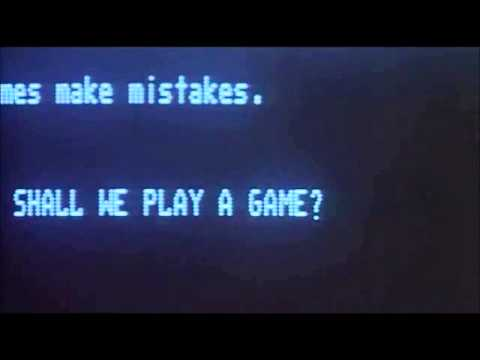

In [26]:
from IPython.display import YouTubeVideo
YouTubeVideo('B53Vlje7mcM')

Now we can use this to play an exciting game.  Watchout Rockstar Games, you may have GTA...but I've got "GTN"!

(GTN=Guess That Number).

Run this code below to pick a random number between 0 and 9, add noise to it and display the result.

In [27]:
difficulty = 15;
correct_answer = random.randrange(0,10);
print (bits2image( addnoise( image2bits( image[correct_answer] ), difficulty/100.0) ));

     
XXX  
  X  
  XX 
 XXX 


## Take a guess:
Enter your guess as to what the character above represents on the line below.

In [28]:
your_guess = 5;

Did you guess correctly?  Run the code below to discover the outcome...

In [29]:
if your_guess == correct_answer:
    print ("OK");
else:
    print ("Global Thermonuclear War Initiated");
    print ("The correct answer was: %d" % correct_answer);

Global Thermonuclear War Initiated
The correct answer was: 1


You can replay this game a few times by rerunning the last 3 code cells.

For best results, I recommending loading a browser window on your XBox360 or PS4 to play GTN at optimum frame-rates.

## Machine Learning Time:  Enter the Tensor!

Activate Tensor Power!

In [30]:
import tensorflow as tf
import numpy as np

We will create a network with one hidden layer (plus and input layer and an output layer).

There will be a weight matrix connecting the input layer to the hidden layer, and a weight matrix connection the hidden layer to the output layer.  In addition, each hidden and output node will have a bias or offset value.

We will initialize all of the trainable parameters to random values chosen from a uniform distribution with low and high values specified by a heuristic from a 2010 paper by Glorot and Bengio.

We will then define some calculations:  h_in, h_out, o_in, y_pred to calculate how the activation values are computed through successive layers.  Then we define cost, accuracy, and train_op, which are procedures to compute the cost (error) or the network, its accuracy, and its weight updates.

Finally, the function returns input_x so that users have access to the network's input layer, label_y so that user's can specify the desired output, accuracy to computer accruacy, cost to compute cost, train_op to train one epoch of data, and y_pred to look at the network output.

Note that the entire function below, doesn't calculate anything, not evern when you run it!  It merely defines <i><b>how</b></i> to calculate it.  Think of it as compiling the code to do the math.  The math isn't yet being performed, the code is just being defined and compiled.

In [31]:
from numpy.random import uniform
DTYPE = 'float32'
EPS = np.finfo(np.double).eps

def construct_model(n_inputs, n_hidden, n_outputs, lr):
    """Declare Parameters
    """
    # initialization from Glorot and Bengio 2010.
    W_hid = tf.Variable( uniform( low=-4 * np.sqrt(6.0 / (n_inputs + n_hidden)), \
                                  high=4 * np.sqrt(6.0 / (n_inputs + n_hidden)),\
                                  size=(n_inputs,n_hidden) \
                                ).astype('float32'), \
                         name='W_h' )
    
    b_hid = tf.Variable( np.zeros( [n_hidden], dtype=DTYPE ), \
                         name='b_h' )

    W_out = tf.Variable( uniform( low=-4 * np.sqrt(6.0 / (n_hidden + n_outputs)),\
                                  high=4 * np.sqrt(6.0 / (n_hidden + n_outputs)),\
                                  size=(n_hidden, n_outputs) \
                                ).astype('float32'), \
                         name='W_o' )
    
    b_out =  tf.Variable( tf.zeros([n_outputs]), 
                          name='b_o' )
    
    input_x = tf.placeholder( "float", [None, n_inputs] ) # create symbolic variables
    
    #The label.
    label_y = tf.placeholder( "float", [None, n_outputs] )
    
    h_in = tf.nn.bias_add(tf.matmul(input_x,W_hid),b_hid) # define net input calculation to hidden units
    h_out = tf.sigmoid(h_in)  # define squashing function (non-linearity) to hidden units
    
    o_in = tf.nn.bias_add(tf.matmul(h_out, W_out), b_out) # define net input calculation to output units
    y_pred = tf.sigmoid(o_in) # define squashing function (non-linearity) to output units
    
    cost = -tf.reduce_mean( label_y * tf.log(y_pred + EPS) + \
                            (1 - label_y) * tf.log(1 - y_pred + EPS) )
        # add EPS to prevent taking logarithm of zeron when y_pred = 0 or 1
        # if label_y and y_pred are both 0, then both top half and bottom half of the equation equal almost zero
        # if label_y and y_pred are both 1, then both top half and bottom half of the equation equal almost zero
        # if label_y and y_pred differ are 0 and 1 (respectively), then top half of the equation is zero and bottom -16
        # if label_y and y_pred differ are 1 and 0 (respectively), then top half of the equation is -16 and bottom zero

    train_op = tf.train.GradientDescentOptimizer(lr).minimize(cost)

    # generate code to compute accuracy
    # if element > 0.5 replace with 1.
    bool_vec = tf.greater(y_pred, 0.5)
    correct_prediction = tf.equal(label_y, tf.cast(bool_vec, tf.float32))
    # convert all boolean to float, to calculate percentage
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    return input_x, label_y, accuracy, cost, train_op, y_pred;


We can use the function as follows to access the inputs, target outputs and functions within the model.

In [32]:
input_x, label_y, accuracy, cost, train_op, y_pred = construct_model( 25, 30, 10, 0.1 )

At this point we have only created and defined our network.  We haven't run anything.

Next, lets generate our training data.

In [33]:
input_data, target_data = perfect_data();  # get some data to use

Below, we create a train_network function which repatedly runs train_op to train the network for a specified number of epochs.


In [34]:
import matplotlib.pyplot as plt

def train_network(epochs):
    sess = tf.Session()   # execute the tensor flow session
    
    
    
    sess.run(tf.global_variables_initializer())   # initialize all the global variables

    train_costs = np.zeros(epochs, dtype='float32');
    train_accuracies = np.zeros(epochs, dtype='float32');
    
    ### TRAINING BEGIN ###
    print ("Epoch  Cost   Accuracy")
    for i in range(epochs):
        train_cost, train_accuracy, _ = sess.run([cost, accuracy, train_op], feed_dict={input_x: input_data, label_y: target_data})
        train_costs[i] = train_cost
        train_accuracies[i] = train_accuracy
        if i % 200 == 0:
            print ("%05d  %5.3f  %5.3f" % (i,train_cost,train_accuracy));
    print ("%05d  %5.3f  %5.3f" % (i,train_cost,train_accuracy));        
    ### TRAINING END ###
    
    return train_costs, train_accuracies, y_pred, sess;

Then we run it for 5000 epochs (finally!).

In [243]:
train_costs, train_accuracies, y_pred, sess = train_network(5000)


Epoch  Cost   Accuracy
00000  1.340  0.510
00200  0.281  0.905
00400  0.234  0.905
00600  0.206  0.925
00800  0.183  0.940
01000  0.167  0.935
01200  0.145  0.930
01400  0.116  0.965
01600  0.111  0.965
01800  0.113  0.950
02000  0.099  0.965
02200  0.098  0.960
02400  0.095  0.960
02600  0.075  0.975
02800  0.071  0.980
03000  0.064  0.980
03200  0.062  0.975
03400  0.062  0.980
03600  0.060  0.990
03800  0.050  0.995
04000  0.059  0.980
04200  0.055  1.000
04400  0.051  1.000
04600  0.056  1.000
04800  0.051  1.000
04999  0.044  1.000


Let's plot it!

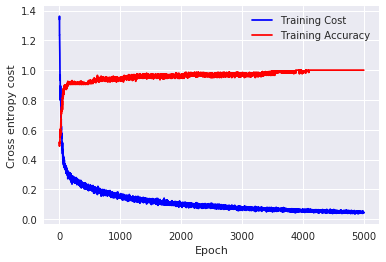

In [244]:
import seaborn as sns
sns.set()
plt.plot(train_costs, '-b', label="Training Cost")
plt.plot(train_accuracies, '-r', label="Training Accuracy")
plt.legend(loc='upper right')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy cost")
plt.show()
plt.savefig("trainperfect.eps")

Error went down, but what is it really outputting for each input pattern?

In [245]:
outputs = sess.run( y_pred, feed_dict={input_x: input_data, label_y: target_data});
for digit in range(0,10):
    print (image[digit]);
    print ([ "%3.1f" % o for o in outputs[digit] ]);
    o = outputs[digit].tolist();
    print ("Prediction: %d" % (o.index(max(o))))
    print;
    print (80*"-");

 XXX 
X   X
X   X
X   X
 XXX 

['0.9', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.1']
Prediction: 0

--------------------------------------------------------------------------------
  X  
 XX  
  X  
  X  
 XXX 

['0.0', '0.9', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
Prediction: 1

--------------------------------------------------------------------------------
 XXX 
    X
   X 
  X  
XXXXX

['0.0', '0.0', '0.9', '0.1', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
Prediction: 2

--------------------------------------------------------------------------------
 XXX 
    X
 XXX 
    X
 XXX 

['0.0', '0.0', '0.0', '0.6', '0.0', '0.0', '0.0', '0.0', '0.1', '0.1']
Prediction: 3

--------------------------------------------------------------------------------
   X 
  XX 
 X X 
XXXXX
   X 

['0.0', '0.0', '0.0', '0.0', '0.9', '0.0', '0.0', '0.0', '0.0', '0.0']
Prediction: 4

--------------------------------------------------------------------------------
XXXXX
X   

Nice! The highest output is always for the corret input pattern.

But, how will it do on noisy data?

In [246]:
input_data = np.array( [ addnoise( image2bits( image[digit] ), 0.0 ) for digit in range(0,10) ] );
output_data = np.array( [ onehot(digit,10) for digit in range(0,10)] );
print(input_data)
print(output_data)
outputs = sess.run( y_pred, feed_dict={input_x: input_data, label_y: target_data});
for digit in range(0,10):
    print (bits2image( input_data[digit] ));
    print ([ "%3.1f" % o for o in outputs[digit] ]);
    o = outputs[digit].tolist();
    print ("Prediction: %d" % (o.index(max(o))))
    print(type(target_data[digit]))
    print(np.where(target_data[digit]==1)[0])
    print;
    print (80*"-");

[[0 1 1 1 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 1 1 0]
 [0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0]
 [0 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 1 1 1]
 [0 1 1 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 1 1 0]
 [0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 0 0 0 1 0]
 [1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0]
 [0 1 1 1 0 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 0]
 [1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0]
 [0 1 1 1 0 1 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 1 1 1 0]
 [0 1 1 1 0 1 0 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0]]
[[1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]]
 XXX 
X   X
X   X
X   X
 XXX 
['0.9', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.1']
Prediction: 0
<type 'numpy.ndarray'>
[0]

--------------------------------------------------------------------------------
  X  
 XX  
  

# Part A

In [247]:
import random

#def gen_noisy_test_data():
'''
Function to generate 7 sets of test data containing 20 random digits
from 0 to 9, with noise levels of 0%, 5%, 10%, 15%, 20%, 25%, 30%, 
respectively.

Returns:
    correct_labels_list: A numpy array of correct targets for the 
                         test.
    test_input_data:     A numpy array of arrays containing randomly 
                         generated digits with noise
'''
noise_levels = [0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30] # List of noise levels
correct_labels_list = [] # List of correct labels
test_input_data = [] # List of test input data

for i, noise in enumerate(noise_levels):
    # Random generate of 20 digits and save into correct_labels_list
    correct_labels = [random.randrange(0,10) for _ in range (0, 20)]
    correct_labels_list.append(correct_labels)

    # Add noise to the random digits in correct_labels
    test_data = [ addnoise( image2bits( image[digit] ), noise ) for digit in correct_labels] ;
    test_input_data.append(test_data)
    
np.vstack(correct_labels_list), np.vstack(test_input_data)

(array([[1, 5, 1, 3, 4, 7, 0, 3, 9, 6, 1, 7, 3, 9, 1, 2, 0, 4, 4, 9],
        [5, 6, 5, 6, 7, 0, 5, 5, 1, 2, 2, 4, 0, 8, 9, 5, 0, 7, 6, 5],
        [6, 5, 8, 7, 2, 9, 6, 3, 3, 7, 0, 5, 3, 1, 7, 9, 0, 8, 3, 4],
        [4, 6, 6, 8, 2, 7, 5, 0, 8, 5, 9, 8, 5, 6, 8, 0, 4, 4, 3, 6],
        [8, 9, 1, 0, 4, 3, 7, 0, 1, 2, 2, 3, 1, 1, 9, 4, 0, 6, 5, 8],
        [6, 9, 0, 2, 0, 3, 8, 0, 5, 2, 8, 9, 1, 8, 7, 8, 7, 4, 1, 7],
        [2, 0, 4, 1, 9, 0, 0, 1, 5, 6, 6, 8, 5, 3, 3, 4, 3, 4, 1, 0]]),
 array([[0, 0, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 0],
        [0, 0, 1, ..., 1, 1, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 1],
        [1, 0, 1, ..., 1, 1, 0],
        [0, 0, 1, ..., 0, 0, 0]]))

In [248]:
#correct_labels_list, test_input_data = gen_noisy_test_data()

In [249]:
test_input_data

[[[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0],
  [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0],
  [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0],
  [0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0],
  [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0],
  [1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
  [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
  [0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0],
  [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0],
  [0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
  [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0],
  [1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
  [0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0

In [263]:
def one_hot_test_target_data(correct_labels_list):
    '''
    Function to one-hot encode the test target digits.
    
    Input:
        correct_labels_list: A list of lists containing targets for each
                             test set.
    
    Returns:
        one_hot_output_data: A list of lists containing one-hot encoded
                             targets.
    '''
    for i in range(len(correct_labels_list)):
        output_data = [ onehot(digit,10) for digit in correct_labels_list[i]]
        one_hot_output_data.append(output_data)
    
    return one_hot_output_data

In [264]:
one_hot_output_data = one_hot_test_target_data(correct_labels_list)

In [266]:
count = 0
one_hot_output_data = []
noise_levels = [0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
for i, test in enumerate(correct_labels_list):
    output_data = [ onehot(digit,10) for digit in correct_labels_list[i]]
    one_hot_output_data.append(output_data)
    #print("Noise Level: {}".format(noise_levels[i]))
    #for j, img in enumerate(test):
    #    print(img)
    #    print(bits2image(img))
    #    print("")
    #    count += 1

In [267]:
one_hot_output_data

[[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]],
 [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 1, 0

In [268]:
from __future__ import division
noise_levels = [0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

def test_model():
    test_accuracy_list_perfect = []
    for i, noise in enumerate(noise_levels):
        print("Noise Level: {}".format(noise_levels[i]))
        outputs = sess.run( y_pred, feed_dict={input_x: test_input_data[i], label_y: one_hot_output_data[i]});
        predicted_correct = 0
        test_accuracy = 0
        for digit in correct_labels_list[i]:
            print (bits2image( test_input_data[i][digit] ));
            print ([ "%3.1f" % o for o in outputs[digit] ]);

            o = outputs[digit].tolist();

            print ("Prediction: %d" % (o.index(max(o))))
            print ("Actual: %d"% (np.where(np.array(one_hot_output_data[i][digit])==1)[0]))
            if o.index(max(o)) == np.where(np.array(one_hot_output_data[i][digit])==1)[0]:
                predicted_correct += 1
                print ("Correct\n")
            else:
                print("Incorrect\n")
            print;
            print (80*"-");
        test_accuracy = (predicted_correct/(len(correct_labels_list[i])))*100
        print("Noise Level: {} Accuracy: {}%\n\n".format(noise, test_accuracy))
        test_accuracy_list_perfect.append(test_accuracy)
    np.vstack(test_accuracy_list_perfect)

In [269]:
def plot_accuracy(x, y):
    '''
    Function to plot the noise level vs test accuracy for the model
    and human.
    '''
    plt.plot(x, y, '-b', label="MLP - Perfect")
    plt.plot(noise_levels, [100, 85, 80, 85, 60, 45, 35], '-r', label="Human")
    #plt.legend(loc='upper right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel("Noise Level (%)")
    plt.ylabel("Test Accuracy (%)")
    plt.title("Noise Level versus Test Accuracy")
    plt.show()
    #plt.savefig("partA.eps", bbox_inches='tight')
    plt.close()
    #plt.savefig("partB-mlp-randomnoisy.eps")

[100.0, 85.0, 100.0, 90.0, 85.0, 60.0, 45.0]


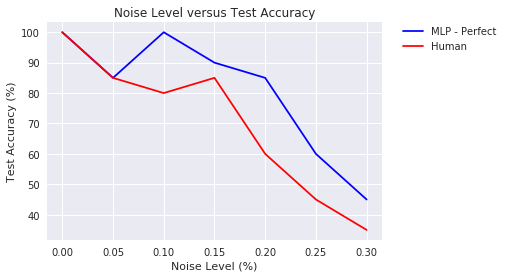

In [270]:
#import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
'''
plt.plot(noise_levels, test_accuracy_list_perfect, '-b', label="MLP - Perfect")
plt.plot(noise_levels, [100, 85, 80, 85, 60, 45, 35], '-r', label="Human")
plt.legend(loc='upper right')
plt.xlabel("Noise Level (%)")
plt.ylabel("Test Accuracy (%)")
plt.title("Noise Level versus Test Accuracy")
#plt.show()
plt.savefig("partA-perfect.pdf")
'''
print(test_accuracy_list_perfect)
plot_accuracy(noise_levels, test_accuracy_list_perfect)

# Part B

In [191]:
import numpy as np;
DTYPE = 'float32'

noise_levels = [0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

def gen_imperfect_data():
    '''
    Function that generates imperfect data for training input.
    10 samples of perfect data and 10 random samples with randomly
    added noise.
    
    Returns:
        imperfect_input_data:   A numpy array of perfect and noisy input
                                training data
        imperfect_output_data:  A numpy array of corresponding labels
                                for imperfect_input_data
    '''
    imperfect_input_data = []
    imperfect_output_data = []
    
    perfect_input = [ image2bits( image[digit] ) for digit in range(0,10) ];
    perfect_output = [ onehot(digit,10) for digit in range(0,10) ];
    selected_idx = [random.randrange(0,10) for _ in range (0, 10)]
    random_input = [image2bits( image[digit] ) for digit in selected_idx ];
    random_output = [ onehot(digit,10) for digit in selected_idx ];
    
    imperfect_input_data =  perfect_input.append(random_input)
    imperfect_output_data = perfect_output.append(random_output)
    
    return np.vstack(imperfect_input_data).astype(DTYPE), np.vstack(imperfect_output_data).astype(DTYPE)

In [192]:
import tensorflow as tf
import numpy as np

In [193]:
from numpy.random import uniform
DTYPE = 'float32'
EPS = np.finfo(np.double).eps

def construct_model(n_inputs, n_hidden, n_outputs, lr):
    """Declare Parameters
    """
    # initialization from Glorot and Bengio 2010.
    W_hid = tf.Variable( uniform( low=-4 * np.sqrt(6.0 / (n_inputs + n_hidden)), \
                                  high=4 * np.sqrt(6.0 / (n_inputs + n_hidden)),\
                                  size=(n_inputs,n_hidden) \
                                ).astype('float32'), \
                         name='W_h' )
    
    b_hid = tf.Variable( np.zeros( [n_hidden], dtype=DTYPE ), \
                         name='b_h' )

    W_out = tf.Variable( uniform( low=-4 * np.sqrt(6.0 / (n_hidden + n_outputs)),\
                                  high=4 * np.sqrt(6.0 / (n_hidden + n_outputs)),\
                                  size=(n_hidden, n_outputs) \
                                ).astype('float32'), \
                         name='W_o' )
    
    b_out =  tf.Variable( tf.zeros([n_outputs]), 
                          name='b_o' )
    
    input_x = tf.placeholder( "float", [None, n_inputs] ) # create symbolic variables
    
    #The label.
    label_y = tf.placeholder( "float", [None, n_outputs] )
    
    h_in = tf.nn.bias_add(tf.matmul(input_x,W_hid),b_hid) # define net input calculation to hidden units
    h_out = tf.sigmoid(h_in)  # define squashing function (non-linearity) to hidden units
    
    o_in = tf.nn.bias_add(tf.matmul(h_out, W_out), b_out) # define net input calculation to output units
    y_pred = tf.sigmoid(o_in) # define squashing function (non-linearity) to output units
    
    cost = -tf.reduce_mean( label_y * tf.log(y_pred + EPS) + \
                            (1 - label_y) * tf.log(1 - y_pred + EPS) )
        # add EPS to prevent taking logarithm of zeron when y_pred = 0 or 1
        # if label_y and y_pred are both 0, then both top half and bottom half of the equation equal almost zero
        # if label_y and y_pred are both 1, then both top half and bottom half of the equation equal almost zero
        # if label_y and y_pred differ are 0 and 1 (respectively), then top half of the equation is zero and bottom -16
        # if label_y and y_pred differ are 1 and 0 (respectively), then top half of the equation is -16 and bottom zero

    train_op = tf.train.GradientDescentOptimizer(lr).minimize(cost)

    # generate code to compute accuracy
    # if element > 0.5 replace with 1.
    bool_vec = tf.greater(y_pred, 0.5)
    correct_prediction = tf.equal(label_y, tf.cast(bool_vec, tf.float32))
    # convert all boolean to float, to calculate percentage
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    return input_x, label_y, accuracy, cost, train_op, y_pred;

In [194]:
input_x, label_y, accuracy, cost, train_op, y_pred = construct_model( 25, 30, 10, 0.1 )

# Train/Test model with 10 noisy samples @ 5% noise level

In [195]:
#input_data, target_data = imperfect_data(noise_levels[1])

In [196]:
import matplotlib.pyplot as plt

def train_network(epochs):
    sess = tf.Session()   # execute the tensor flow session
    
    
    
    sess.run(tf.global_variables_initializer())   # initialize all the global variables

    train_costs = np.zeros(epochs, dtype='float32');
    train_accuracies = np.zeros(epochs, dtype='float32');
    
    ### TRAINING BEGIN ###
    print ("Epoch  Cost   Accuracy")
    for i in range(epochs):
        input_data, target_data = gen_imperfect_data() # Generates imperfect data every epoch
        train_cost, train_accuracy, _ = sess.run([cost, accuracy, train_op], feed_dict={input_x: input_data, label_y: target_data})
        train_costs[i] = train_cost
        train_accuracies[i] = train_accuracy
        if i % 200 == 0:
            print ("%05d  %5.3f  %5.3f" % (i,train_cost,train_accuracy));
    print ("%05d  %5.3f  %5.3f" % (i,train_cost,train_accuracy));        
    ### TRAINING END ###
    
    return train_costs, train_accuracies, y_pred, sess;

In [220]:
#train_costs, train_accuracies, y_pred, sess = train_network(5000)
plt.plot(train_costs, '-b', label="Training Cost")
plt.plot(train_accuracies, '-r', label="Training Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy cost")
plt.savefig("partB-mlp-randomnoisy-train.eps", bbox_inches='tight')
#plt.show()
#plt.close()
#plt.savefig("partB-mlp-randomnoisy-train.eps")

In [218]:
from __future__ import division

noise_levels = [0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

from __future__ import division

def test_model(test_input_data, one_hot_output_data):
    '''
    Function for testing the trained MLP model using the 
    test_input_data and correct_labels_list from Part A.
    
    Returns:
        test_accuracy_list: A numpy array of test accuracies
                            done at all noise levels.
    '''
    test_accuracy_list = []

    for i, noise in enumerate(noise_levels):
        print("Noise Level: {}".format(noise_levels[i]))
        
        # Feed random noisy test_input_data and corresponding one_hot labels
        outputs = sess.run( y_pred, feed_dict={input_x: test_input_data[i], label_y: one_hot_output_data[i]});
        
        predicted_correct = 0 # Correct prediction count
        
        for digit in correct_labels_list[i]:
            print (bits2image( test_input_data[i][digit] ));
            print ([ "%3.1f" % o for o in outputs[digit] ]);

            o = outputs[digit].tolist();
            
            # Print prediction and actual answer
            print ("Prediction: %d" % (o.index(max(o))))
            print ("Actual: %d"% (np.where(np.array(one_hot_output_data[i][digit])==1)[0]))
            
            # Check if classification right or wrong
            if o.index(max(o)) == np.where(np.array(one_hot_output_data[i][digit])==1)[0]:
                predicted_correct += 1
                print ("Correct\n")
            else:
                print("Incorrect\n")
            print;
            print (80*"-");
            
        # Compute the test accuracy for this test set and append to list
        test_accuracy = (predicted_correct/(len(correct_labels_list[i])))*100
        print("Noise Level: {} Accuracy: {}%\n\n".format(noise, test_accuracy))
        test_accuracy_list.append(test_accuracy)

    return np.vstack(test_accuracy_list)

def plot_accuracy(x, y, z):
    '''
    Function to plot the noise level vs test accuracy for the model
    and human.
    '''
    plt.plot(x, y, '-b', label="MLP - Random Noisy")
    plt.plot(x, z, '-m', label="MLP - Perfect")
    plt.plot(noise_levels, [100, 85, 80, 85, 60, 45, 35], '-r', label="Human")
    #plt.legend(loc='upper right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel("Noise Level (%)")
    plt.ylabel("Test Accuracy (%)")
    plt.title("Noise Level versus Test Accuracy")
    #plt.show()
    plt.savefig("partB-mlp-randomnoisy.eps", bbox_inches='tight')
    plt.close()
    #plt.savefig("partB-mlp-randomnoisy.eps")

In [199]:
y = test_model()

Noise Level: 0.0
 XXX 
X   X
 XXX 
X   X
 XXX 
['0.0', '0.0', '0.0', '0.1', '0.0', '0.0', '0.1', '0.0', '0.6', '0.1']
Prediction: 8
Actual: 8
Correct


--------------------------------------------------------------------------------
 XXX 
    X
   X 
  X  
XXXXX
['0.0', '0.0', '0.9', '0.1', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
Prediction: 2
Actual: 2
Correct


--------------------------------------------------------------------------------
   X 
  XX 
 X X 
XXXXX
   X 
['0.0', '0.0', '0.0', '0.0', '0.9', '0.0', '0.0', '0.0', '0.0', '0.0']
Prediction: 4
Actual: 4
Correct


--------------------------------------------------------------------------------
   X 
  XX 
 X X 
XXXXX
   X 
['0.0', '0.0', '0.0', '0.0', '0.9', '0.0', '0.0', '0.0', '0.0', '0.0']
Prediction: 4
Actual: 4
Correct


--------------------------------------------------------------------------------
   X 
  XX 
 X X 
XXXXX
   X 
['0.0', '0.0', '0.0', '0.0', '0.9', '0.0', '0.0', '0.0', '0.0', '0.0']
Prediction: 4
Actu

In [219]:
plot_accuracy(noise_levels, y, test_accuracy_list_perfect)

In [231]:
y

array([[ 100.],
       [  85.],
       [ 100.],
       [  90.],
       [  85.],
       [  60.],
       [  45.]])